In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
ss = pd.read_csv('sample_submission.csv')

In [6]:
print(train.shape)
print(test.shape)
train.info()
train.dropna(inplace=True)

(27481, 4)
(3534, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


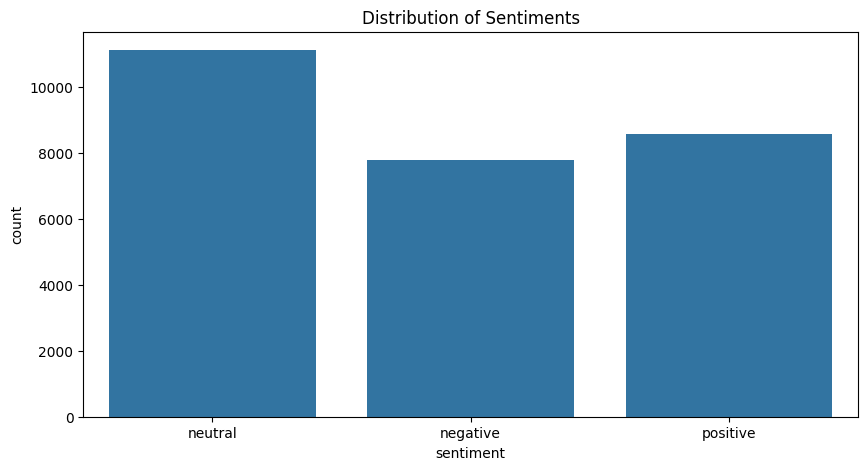

In [7]:
plt.figure(figsize=(10,5))
sns.countplot(x='sentiment', data=train)
plt.title('Distribution of Sentiments')
plt.show()

In [8]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

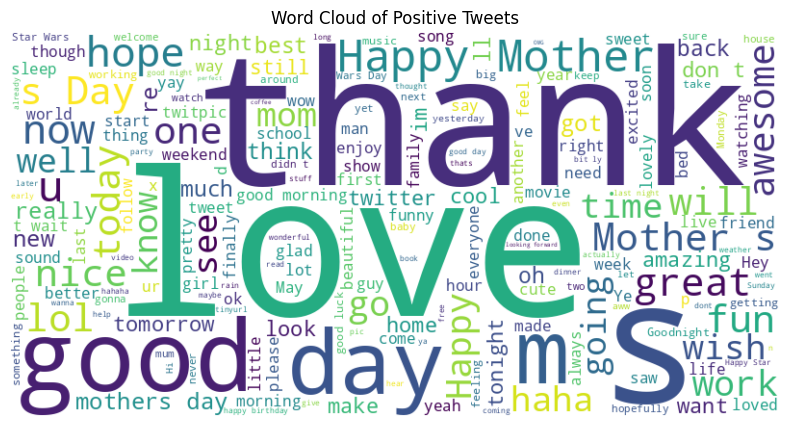

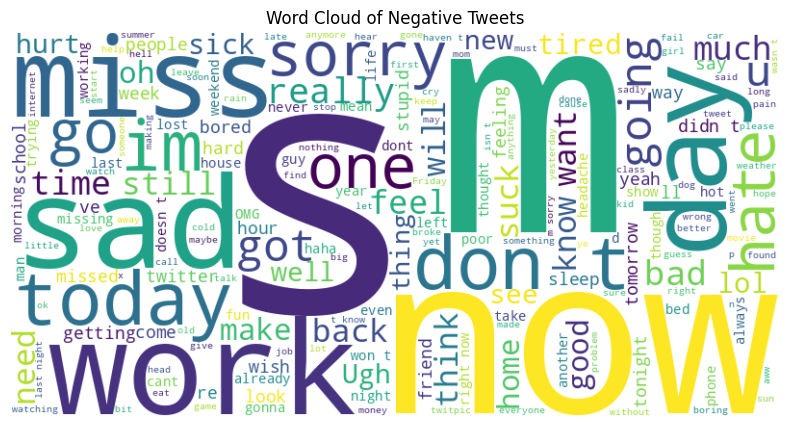

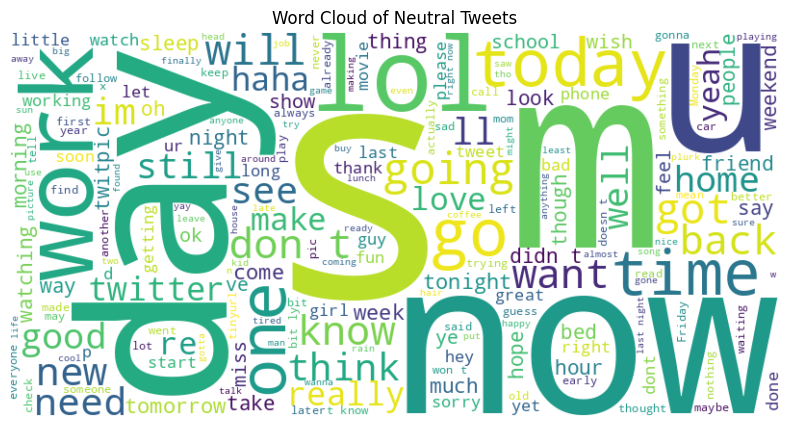

In [9]:
for sentiment in ['positive', 'negative', 'neutral']:
    text = ' '.join(train[train['sentiment'] == sentiment]['text'])
    plot_wordcloud(text, f'Word Cloud of {sentiment.capitalize()} Tweets')

In [10]:
import re
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

In [11]:
train['clean_text'] = train['text'].apply(clean_text)
train['word_count'] = train['clean_text'].apply(lambda x: len(x.split()))

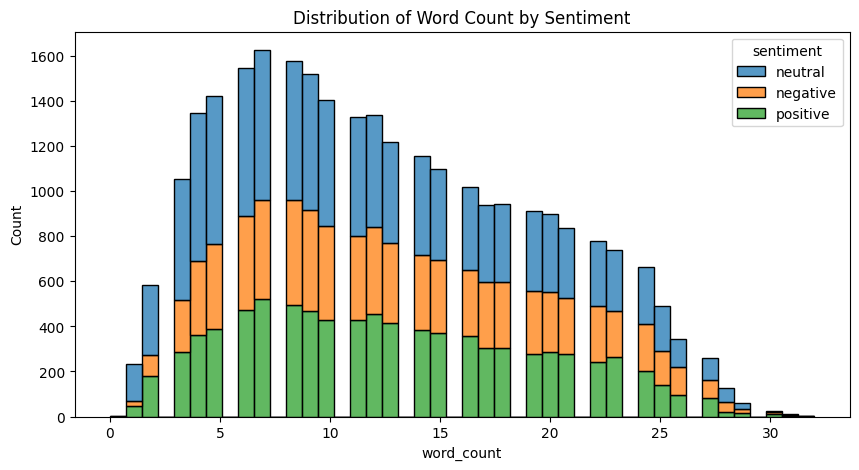

In [12]:
plt.figure(figsize=(10,5))
sns.histplot(data=train, x='word_count', hue='sentiment', multiple='stack')
plt.title('Distribution of Word Count by Sentiment')
plt.show()

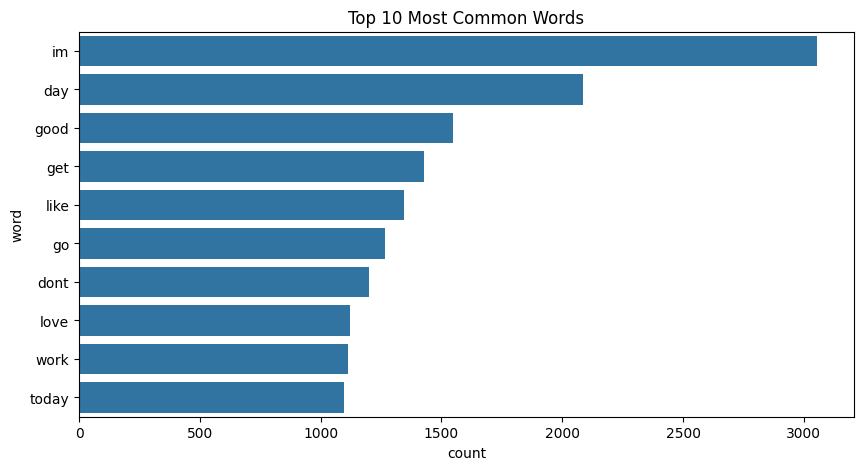

In [13]:
from collections import Counter

def get_top_words(texts, n=10):
    words = ' '.join(texts).split()
    words = [word for word in words if word not in stopwords.words('english')]
    return pd.DataFrame(Counter(words).most_common(n), columns=['word', 'count'])

top_words = get_top_words(train['clean_text'])
plt.figure(figsize=(10,5))
sns.barplot(x='count', y='word', data=top_words)
plt.title('Top 10 Most Common Words')
plt.show()

In [14]:
import numpy as np
from scipy import stats
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [15]:
train['text_length'] = train['text'].apply(len)
train['selected_text_length'] = train['selected_text'].apply(len)

fig = make_subplots(rows=1, cols=2, subplot_titles=('Text Length Distribution', 'Selected Text Length Distribution'))
fig.add_trace(go.Histogram(x=train['text_length'], name='Text Length'), row=1, col=1)
fig.add_trace(go.Histogram(x=train['selected_text_length'], name='Selected Text Length'), row=1, col=2)
fig.update_layout(height=400, width=900, title_text="Distribution of Text Lengths")
fig.show()

In [16]:
fig = px.box(train, x='sentiment', y='text_length', color='sentiment',
             title='Text Length Distribution by Sentiment')
fig.show()

In [17]:
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
train['selected_word_count'] = train['selected_text'].apply(lambda x: len(str(x).split()))

fig = make_subplots(rows=1, cols=2, subplot_titles=('Word Count Distribution in Text', 'Word Count Distribution in Selected Text'))
fig.add_trace(go.Histogram(x=train['word_count'], name='Word Count in Text'), row=1, col=1)
fig.add_trace(go.Histogram(x=train['selected_word_count'], name='Word Count in Selected Text'), row=1, col=2)
fig.update_layout(height=400, width=900, title_text="Distribution of Word Counts")
fig.show()

In [18]:
def jaccard_similarity(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

train['jaccard_similarity'] = train.apply(lambda row: jaccard_similarity(row['text'], row['selected_text']), axis=1)

fig = px.box(train, x='sentiment', y='jaccard_similarity', color='sentiment',
             title='Jaccard Similarity Distribution by Sentiment')
fig.show()

In [19]:
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def get_top_words(df, sentiment, n=10):
    words = ' '.join(df[df['sentiment'] == sentiment]['text']).lower().split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return pd.DataFrame(Counter(words).most_common(n), columns=['word', 'count'])

sentiments = ['positive', 'negative', 'neutral']
fig = make_subplots(rows=1, cols=3, subplot_titles=sentiments)

for i, sentiment in enumerate(sentiments, 1):
    top_words = get_top_words(train, sentiment)
    fig.add_trace(go.Bar(x=top_words['count'], y=top_words['word'], orientation='h', name=sentiment), row=1, col=i)

fig.update_layout(height=400, width=1200, title_text="Top 10 Words by Sentiment")
fig.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
fig = px.scatter(train, x='text_length', y='selected_text_length', color='sentiment',
                 title='Correlation between Text Length and Selected Text Length')
fig.show()

In [21]:
import string

def count_punctuation(text):
    return sum([1 for char in text if char in string.punctuation])

train['punctuation_count'] = train['text'].apply(count_punctuation)

fig = px.box(train, x='sentiment', y='punctuation_count', color='sentiment',
             title='Punctuation Count Distribution by Sentiment')
fig.show()